### Spectrum Equation
$$
R(O^-, H)_{(\lambda)} = \frac{bb_{(\lambda)}}{2 K_{(\lambda)}} + \left( R_{b(\lambda)} - \frac{bb_{(\lambda)}}{2 K_{(\lambda)}}\right) e^{-2K_{(\lambda)} H}
$$

Where:
 - $R(O^-, H)$ is the reflectance below the water  (i.e. glint corrected)
 - $bb_{(\lambda)}$ is the backscatter coefficient
 - $K_{(\lambda)}$ is the attenuation coefficient
 - $R_{b(\lambda)}$ is the bottom reflectance

### Glint Correction
 - Subtract the infrared intensity band from the entire spectrum

### Task: How to accurately retrieve the bottom reflectance from the spectrum?


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

# stats/fitting
from scipy.optimize import curve_fit, minimize
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.decomposition import PCA
import multiprocess as mp
# import multiprocessing as mp
from functools import partial

# custom
from reflectance import spectrum_utils
AOP_model = spectrum_utils.AOP_model

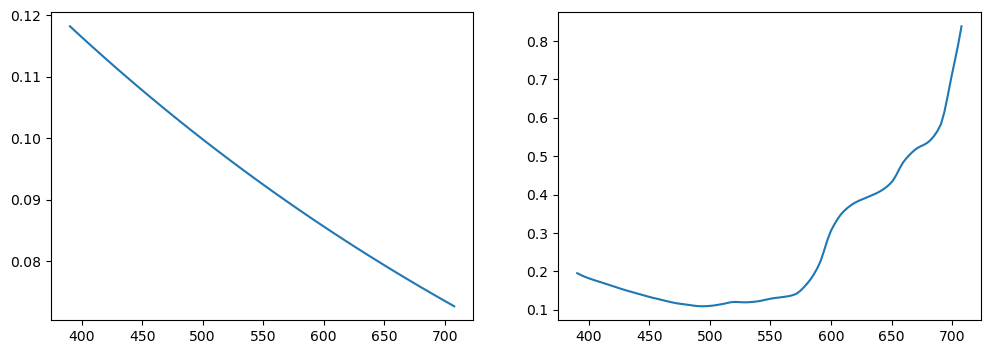

In [3]:
# AOP model is model for function with wavelength of bb and Kd
wv = AOP_model.index
# visualise models for bb and Kd
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(wv, AOP_model.loc[wv].bb_m + AOP_model.loc[wv].bb_c, label="bb model, Group 1")
ax[1].plot(wv, AOP_model.loc[wv].Kd_m + AOP_model.loc[wv].Kd_c, label="Kd model, Group 1");

In [4]:
# benthic counts data
validation_data = pd.read_csv('data/CORAL_validation_data.csv')
# spectral data (PRISM-measured reflectance from nearby pixels)
spectra_raw = pd.read_csv('data/CORAL_validation_spectra.csv')
spectra_raw.columns = spectra_raw.columns.astype(float)

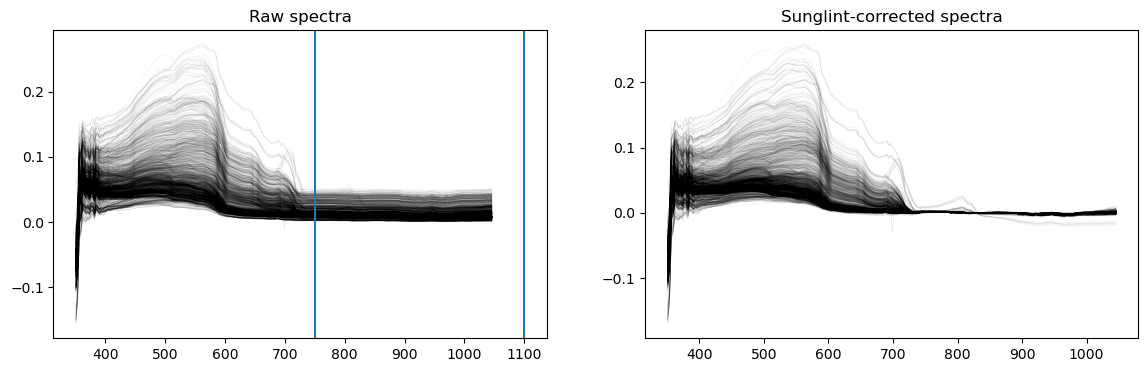

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);
# NIR waveband: (https://www.lidsen.com/journals/aeer/aeer-02-03-017)
ax[0].axvline(750)
ax[0].axvline(1100)
ax[0].set_title("Raw spectra")

# sun glint correction - subtract values between 727 and 957 (NIR) from rest of data
ind = (spectra_raw.columns > 727) & (spectra_raw.columns < 957)
spectra_corrected = spectra_raw.subtract(spectra_raw.loc[:, ind].mean(axis=1), axis=0)
# plot corrected spectra
ax[1].plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);
ax[1].set_title("Sunglint-corrected spectra");

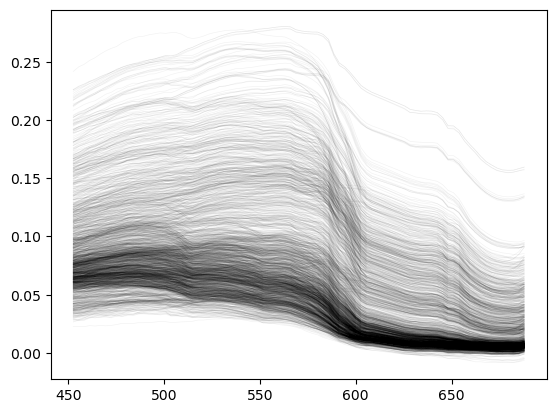

In [6]:
# calculate sub-surface reflectance (from Lee et al. 1998)
spectra_corrected = spectra_corrected / (0.518 + 1.562 * spectra_corrected)
# clip spectra to AOP valid range (instrument calibration limitations)
ind = (spectra_corrected.columns > 450) & (spectra_corrected.columns < 690)
prism_spectra = spectra_corrected.loc[:, ind]
plt.plot(prism_spectra.columns, prism_spectra.values.T, color=(0,0,0,0.05), lw=0.5);

### Observations
- R2 does a pretty terrible job of describing goodness of fit
### TODO
- Is this covariance matrix useful?
- Some spectra e.g. i=888 are weird and jagged: is there a way to quantify and investigate these?

# Average Component-based Rb model

## Visualising spectra

In [7]:
f = 'reflectance/resources/spectral_library_clean_v3_PRISM_wavebands.csv'
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)
# clip to valid wv range
df = df.loc[:, prism_spectra.columns]

cats = df.index.unique()  # get categories

end_members = {}
for cat in cats:
    ind = df.index == cat
    # select all spectra in category and calculate mean spectrum
    end_members[cat] = df.loc[ind].mean(axis=0)
# create array of average spectrum for each category
end_member_array = np.array([spectrum.values for spectrum in end_members.values()])

print('number of endmembers: ', len(end_member_array))
df.head()

number of endmembers:  11


,452.642775,455.475056,458.307394,461.139788,463.972238,466.804744,469.637306,472.469925,475.302600,478.135331,...,662.383497,665.219940,668.056439,670.892995,673.729607,676.566275,679.402999,682.239779,685.076616,687.913509
wavelength,,,,,,,,,,,,,,,,,,,,,
algae_crustose_coralline,0.024956,0.025307,0.025593,0.025889,0.026249,0.026669,0.027123,0.027563,0.027943,0.028233,...,0.049980,0.046018,0.042525,0.039782,0.037933,0.037039,0.037104,0.038188,0.040405,0.043873
algae_crustose_coralline,0.026762,0.027168,0.027538,0.027888,0.028217,0.028544,0.028896,0.029274,0.029645,0.029975,...,0.050251,0.045835,0.041945,0.038914,0.036896,0.035915,0.035968,0.037139,0.039624,0.043634
algae_crustose_coralline,0.047371,0.048106,0.048553,0.048921,0.049452,0.050271,0.051370,0.052624,0.053837,0.054839,...,0.109760,0.101359,0.093901,0.088094,0.084302,0.082658,0.083223,0.086160,0.091666,0.099919
algae_crustose_coralline,0.021885,0.022216,0.022436,0.022594,0.022775,0.023056,0.023476,0.024008,0.024575,0.025109,...,0.056447,0.052379,0.048849,0.046283,0.044905,0.044773,0.045785,0.047909,0.051187,0.055683
algae_crustose_coralline,0.015678,0.015880,0.016051,0.016234,0.016447,0.016688,0.016966,0.017266,0.017577,0.017888,...,0.037927,0.034945,0.032384,0.030518,0.029474,0.029246,0.029774,0.031100,0.033334,0.036624


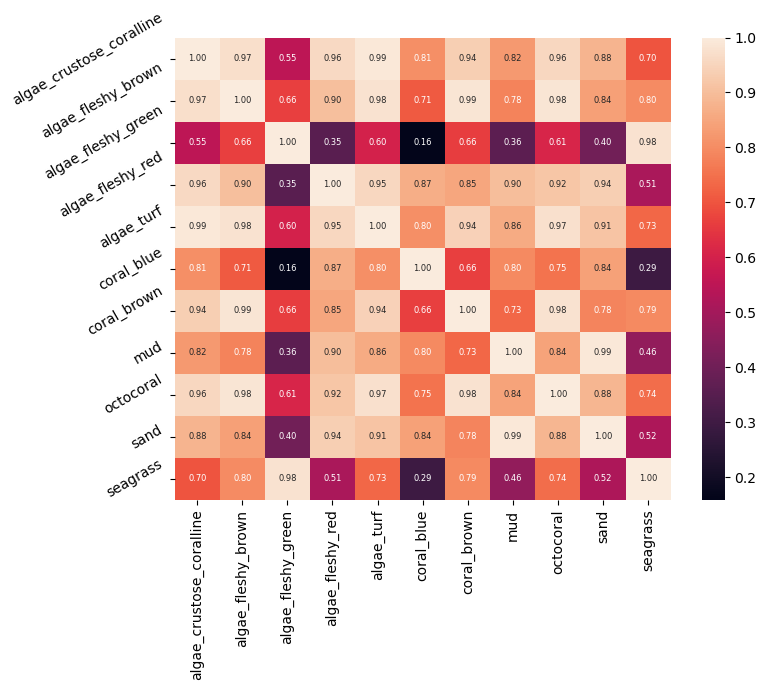

In [8]:
# visualise correlation between end-members
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(end_member_array), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(cats, rotation=90)
ax.set_yticklabels(cats, rotation=30);

In [9]:
# plot exponential decay function as function of wavelength and depth: sea at which depths peaks become invisible
# spectral angle may help with optimisation tolerance

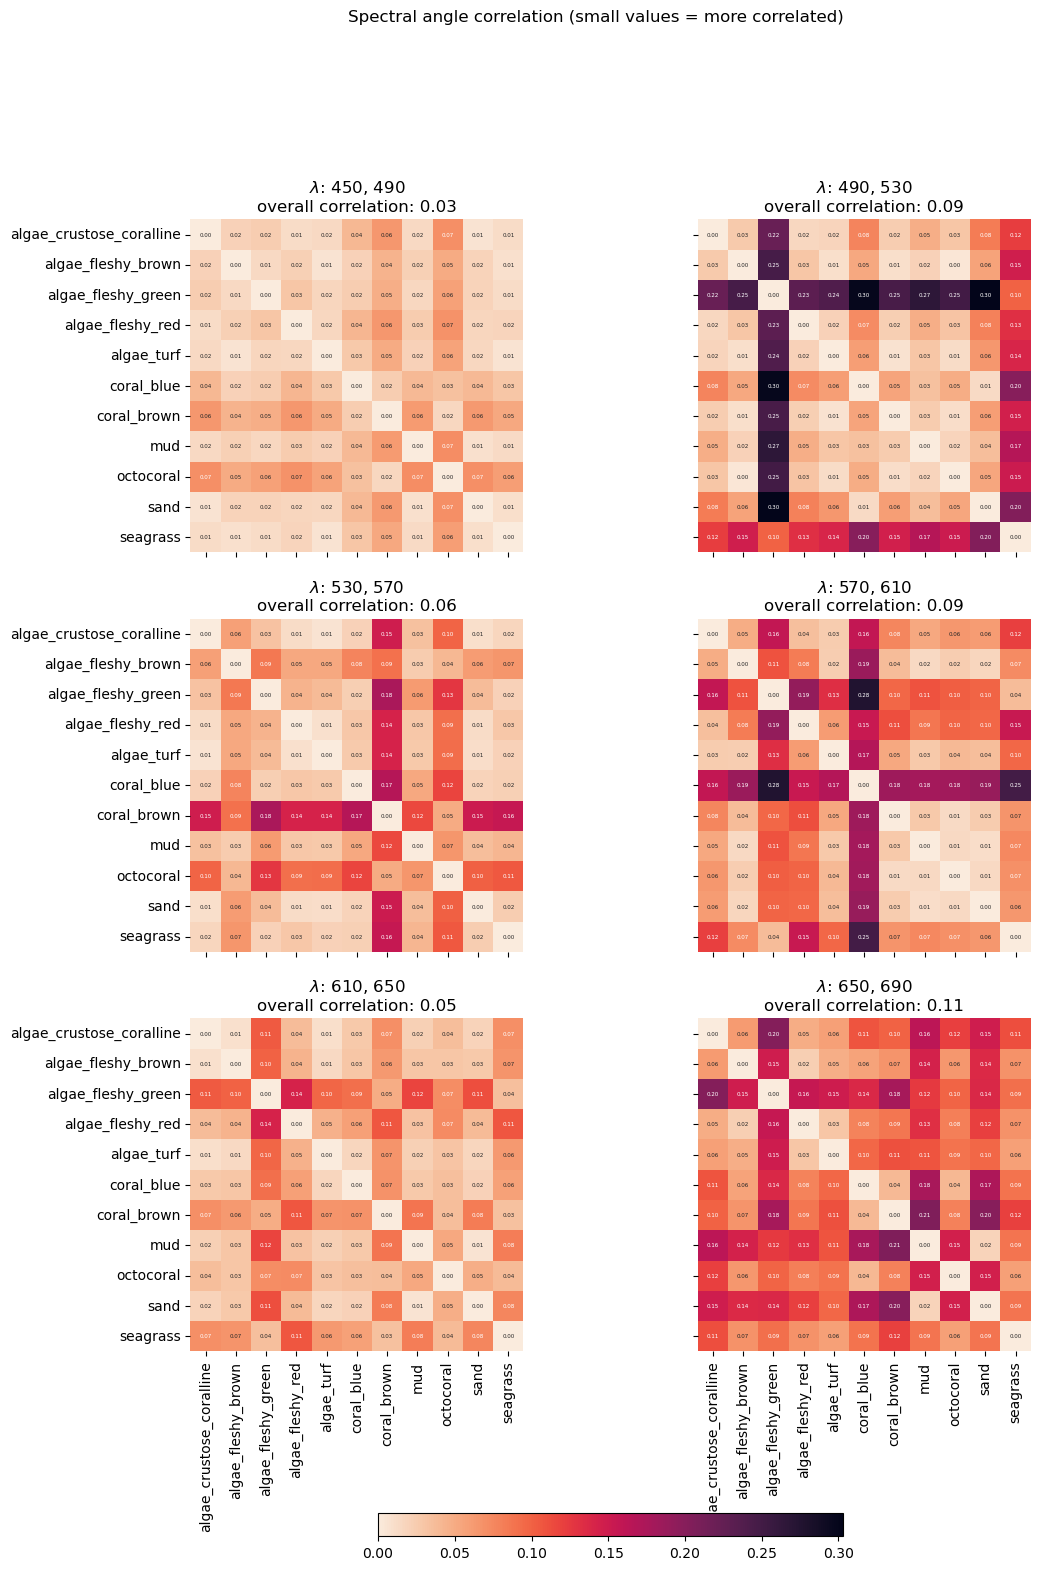

In [10]:
corr_type = "spectral_angle"

def compute_correlation(end_member_array: np.ndarray, corr_type: str = 'pearson') -> np.ndarray:
    """
    Compute correlation matrix between end-members.
    """
    if corr_type == 'pearson':
        return np.corrcoef(end_member_array)
    elif corr_type == "spectral_angle":
        return spectrum_utils.spectral_angle_correlation_matrix(end_member_array)
    else:
        raise ValueError(f"Invalid corr_type. Must be one of 'pearson' or 'spectral_angle'. Received: {corr_type}")

# Generate wavelength kernel pairs
min_wv, max_wv = 450, 670
kernel_width = 40
kernel_displacement = 40
wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]

corr_matrices = [compute_correlation(end_member_array[:, (prism_spectra.columns > min(wvs)) & (prism_spectra.columns < max(wvs))], corr_type=corr_type) for wvs in wv_pairs]
min_corr = min(matrix.min() for matrix in corr_matrices)
max_corr = max(matrix.max() for matrix in corr_matrices)

all_kernel_corrs = {}
num_rows = int(np.ceil(len(wv_pairs)/2))
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 7*num_rows), sharex=True, sharey=True)

if corr_type == "spectral_angle":
    cmap = "rocket_r"
    plt.suptitle("Spectral angle correlation (small values = more correlated)")
else:
    cmap = "rocket"

for i, (wvs, corr_matrix) in enumerate(zip(wv_pairs, corr_matrices)):
    ax = sns.heatmap(corr_matrix, annot=True, fmt='.2f',
                     annot_kws={'fontsize':4}, ax=axes.flatten()[i],
                     vmin=min_corr, vmax=max_corr, cbar_kws={'shrink': 0.8}, cbar=False, cmap=cmap)  # Use global min/max for vmin/vmax
    
    ax.set_xticklabels(cats, rotation=90)
    ax.set_yticklabels(cats, rotation=0)
    
    # calculate the mean of the upper triangle of the correlation matrix (excluding diagonal)
    kernel_corr = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)].mean()
    # all_kernel_corrs[wvs] = kernel_corr
    ax.set_title(f"$\\lambda$: {min(wvs)}, {max(wvs)}\noverall correlation: {kernel_corr:.2f}")
    ax.set_aspect("equal")
    
# remove any empty axes
for i in range(len(wv_pairs), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.colorbar(ax.collections[0], ax=axes, orientation='horizontal', fraction=0.2, pad=0.1, shrink=0.5, cmap=cmap)

plt.show()

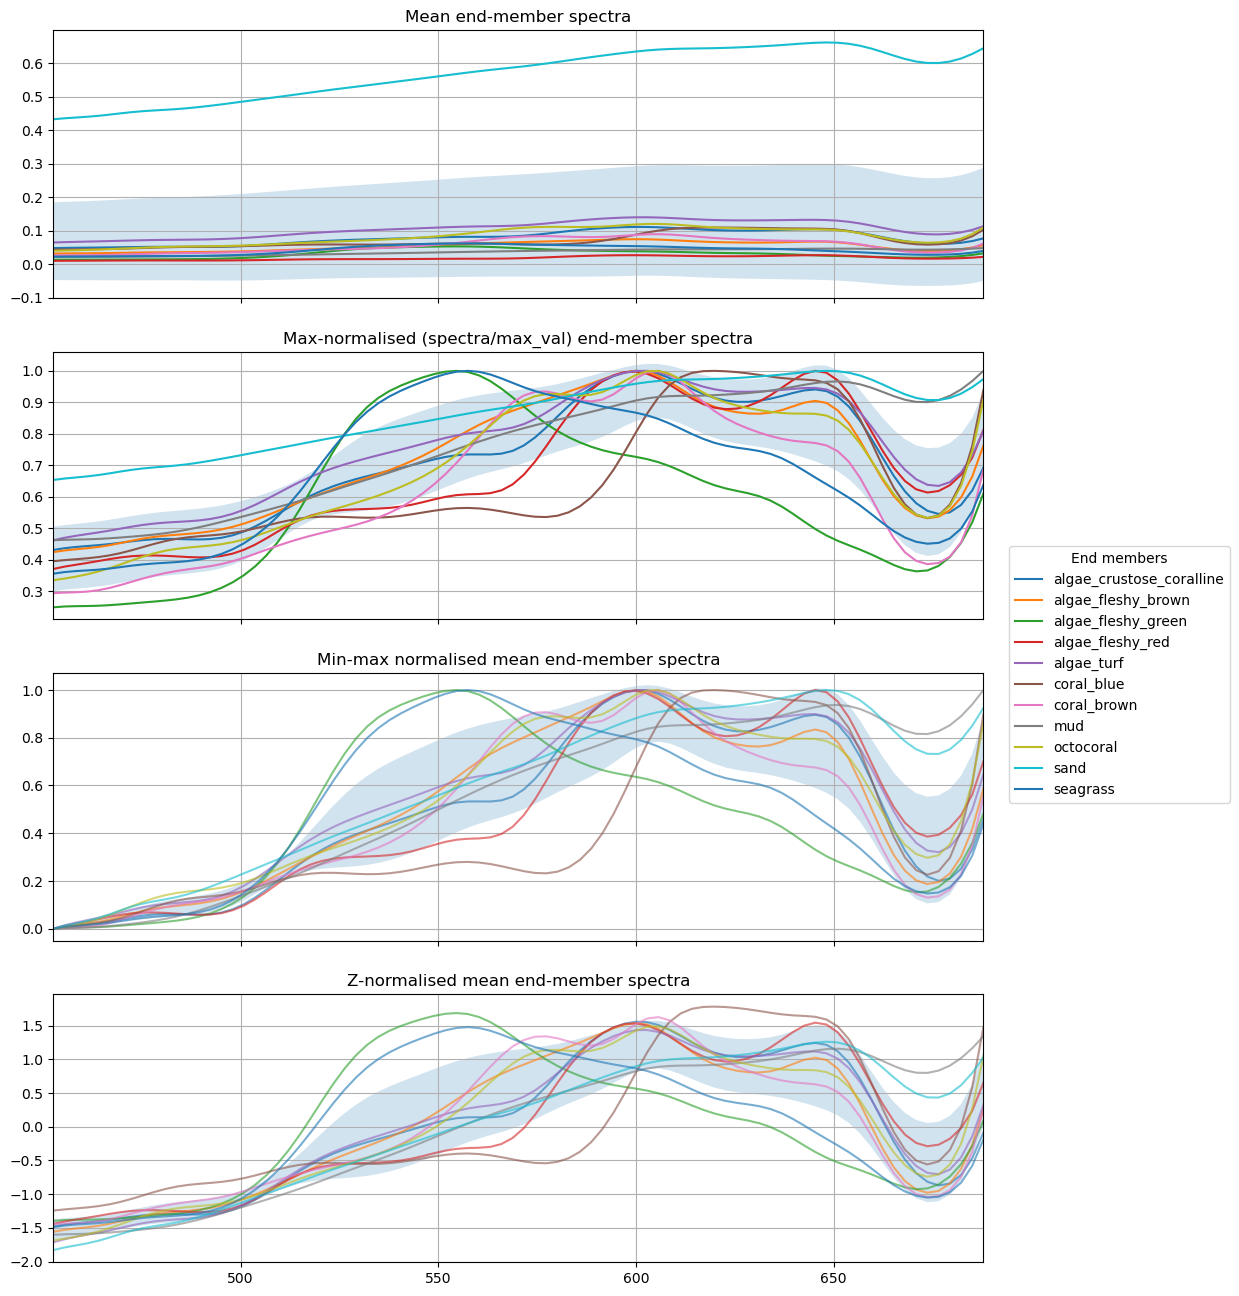

In [11]:
# plot end_members with different scaling
endmembers_max = {cat: spectrum / spectrum.max() for cat, spectrum in end_members.items()}
endmembers_minmax = {cat: (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min()) for cat, spectrum in end_members.items()}
endmembers_znorm = {cat: (spectrum - spectrum.mean(axis=0)) / spectrum.std(axis=0) for cat, spectrum in end_members.items()}
    
fig, ax = plt.subplots(4, 1, figsize=[12,16], sharex=True)
for cat, spectrum in end_members.items():
    ax[0].plot(spectrum.index, spectrum, label=cat)
    ax[1].plot(spectrum.index, endmembers_max[cat], label=cat)
    ax[2].plot(spectrum.index, endmembers_minmax[cat], label=cat, alpha=0.6)
    ax[3].plot(spectrum.index, endmembers_znorm[cat], label=cat, alpha=0.6)
    
# visualise spread of spectra
end_members_maxscale_array = np.array([spectrum.values for spectrum in endmembers_max.values()])
end_members_minmaxscale_array = np.array([spectrum.values for spectrum in endmembers_minmax.values()])
end_members_znormscale_array = np.array([spectrum.values for spectrum in endmembers_znorm.values()])

for i, end_member_spectra in enumerate([end_member_array, end_members_maxscale_array, end_members_minmaxscale_array, end_members_znormscale_array]):
    spectra_std = np.std(end_member_spectra, axis=0)
    spectra_mean = np.mean(end_member_spectra, axis=0)
    ax[i].fill_between(spectrum.index, spectra_mean - spectra_std, spectra_mean + spectra_std, alpha=0.2)
    
ax[0].set_xlim(min(spectrum.index), max(spectrum.index))

ax[0].set_title("Mean end-member spectra");
ax[1].set_title("Max-normalised (spectra/max_val) end-member spectra");
ax[2].set_title("Min-max normalised mean end-member spectra");
ax[3].set_title("Z-normalised mean end-member spectra");

ax[1].legend(bbox_to_anchor=(1.02, 0.3), title="End members")
[a.grid() for a in ax];

# remove spectrum variable
del spectrum

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:93: RuntimeWarning: invalid value encountered in divide
  cos_theta_matrix = dot_product_matrix / norm_matrix


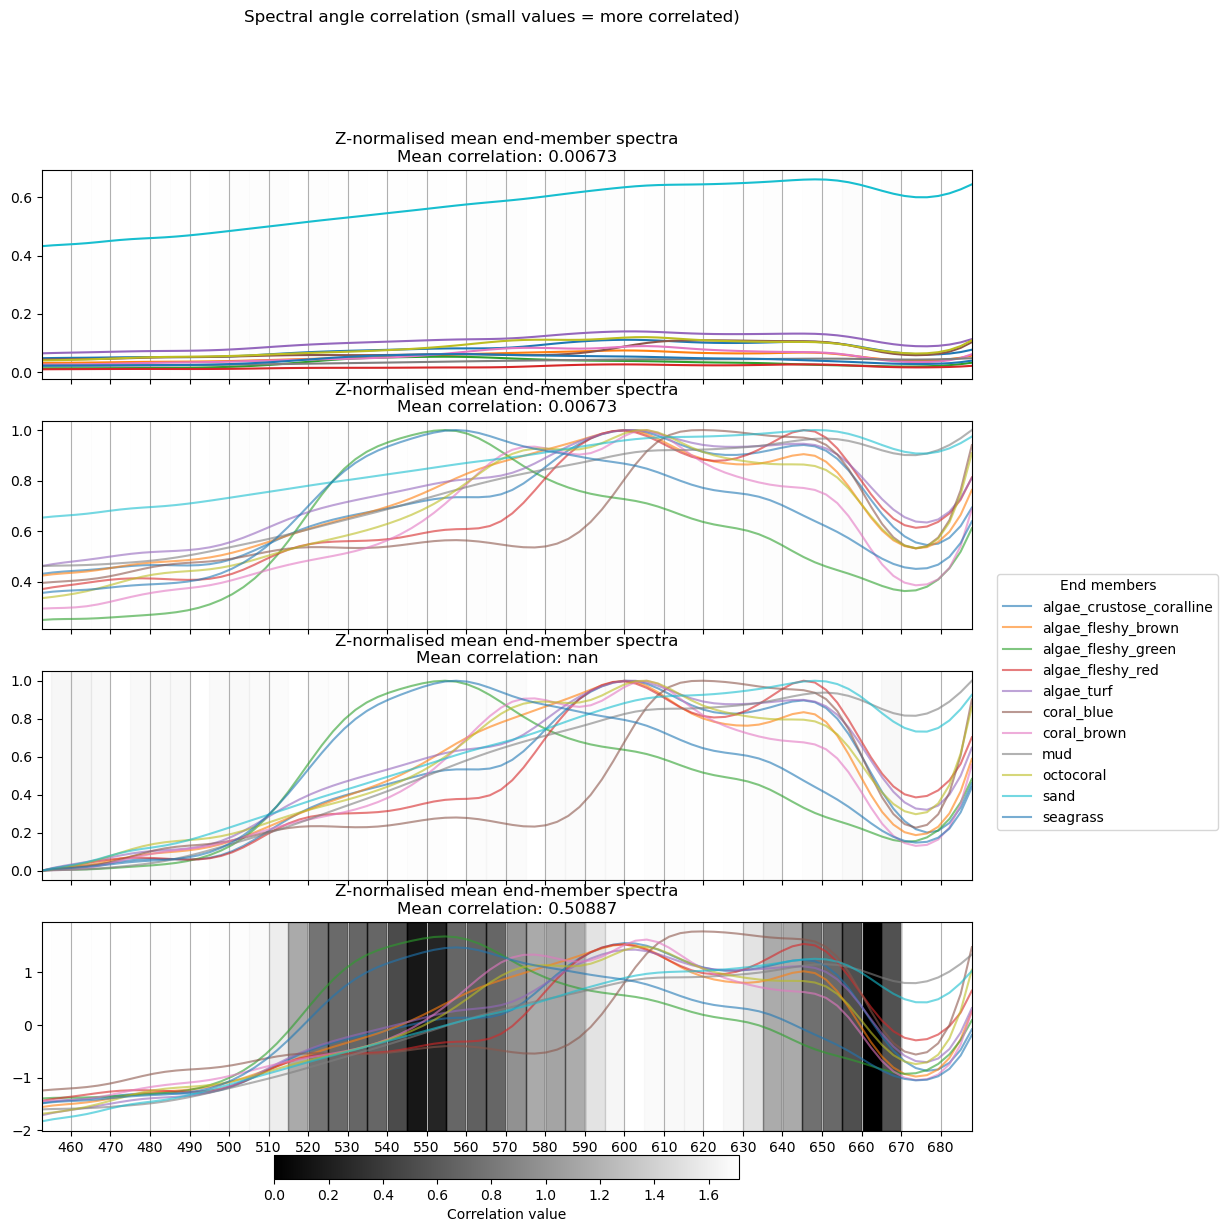

In [12]:
# Generate wavelength kernel pairs
min_wv, max_wv = 450, 670
kernel_width = 5
kernel_displacement = 5
wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]


fig, ax = plt.subplots(4, 1, figsize=[12,16], sharex=True)
for cat, spectrum in end_members.items():
    ax[0].plot(spectrum.index, spectrum, label=cat)
    ax[1].plot(spectrum.index, endmembers_max[cat], label=cat, alpha=0.6)
    ax[2].plot(spectrum.index, endmembers_minmax[cat], label=cat, alpha=0.6)
    ax[3].plot(spectrum.index, endmembers_znorm[cat], label=cat, alpha=0.6)
    
ax[0].set_xlim(min(spectrum.index), max(spectrum.index))

ax[1].legend(bbox_to_anchor=(1.02, 0.3), title="End members")
# [a.grid(which='minor') for a in ax];
for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(10))
    a.grid('major', axis='x')


spectra_kernel_corrs = {}
# for each type of spectral normalisation method
for i, endmembers in enumerate([end_member_array, end_members_maxscale_array, end_members_minmaxscale_array, end_members_znormscale_array]):
    # calculate correlation matrices between end-members
    corr_matrices = [compute_correlation(endmembers[:, (prism_spectra.columns > min(wvs)) & (prism_spectra.columns < max(wvs))], corr_type=corr_type) for wvs in wv_pairs]
    # calculate mean correlation for each kernel pair
    kernel_corrs = [corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)].mean() for corr_matrix in corr_matrices]
    spectra_kernel_corrs[i] = kernel_corrs
    
    ax[i].set_title(f"Mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
    ax[i].set_title(f"Max-normalised (spectra/max_val) end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
    ax[i].set_title(f"Min-max normalised mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
    ax[i].set_title(f"Z-normalised mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")


min_corr = min([value for sublist in spectra_kernel_corrs.values() for value in sublist])
max_corr = max([value for sublist in spectra_kernel_corrs.values() for value in sublist])

spectra_kernel_corrs_norms = {k: (v - min_corr) / (max_corr - min_corr) for k, v in (spectra_kernel_corrs.items())}
spectra_kernel_corrs_norms

for i, endmembers in enumerate([end_member_array, end_members_maxscale_array, end_members_minmaxscale_array, end_members_znormscale_array]):    # min_corr = min(all_kernel_corrs.values())
    for j, wvs in enumerate(wv_pairs):
        endmember_corrs = spectra_kernel_corrs_norms[i]
        if corr_type == "spectral_angle":
            alpha = (endmember_corrs[j])
        else:
            alpha = 0.3*(1 - endmember_corrs[j])
        ax[i].axvspan(wvs[0], wvs[1], color=(0,0,0,alpha))
        
if corr_type == "spectral_angle":
    plt.suptitle("Spectral angle correlation (small values = more correlated)")
# plot a colourbar of correlation values
sm = plt.cm.ScalarMappable(cmap="grey", norm=plt.Normalize(vmin=min_corr, vmax=max_corr))
plt.colorbar(sm, ax=ax, orientation='horizontal', label="Correlation value", fraction=0.2, pad=0.02, shrink=0.5, alpha=1)

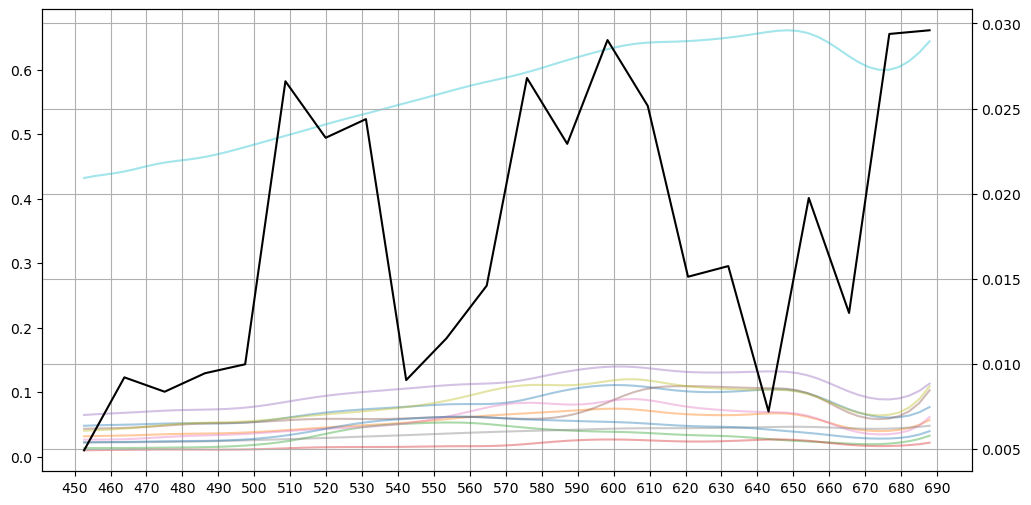

In [13]:
min_wv, max_wv = 450, 670
kernel_width = 10
kernel_displacement = 10
wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]


f, ax = plt.subplots(1, figsize=(12, 6))

choice_endmembers = end_members
choice_array = np.array([spectrum.values for spectrum in choice_endmembers.values()])

x_corrs = np.linspace(spectrum.index.min(), spectrum.index.max(), len(wv_pairs))
ax2 = ax.twinx()
for cat, spectrum in end_members.items():
    ax.plot(spectrum.index, choice_endmembers[cat], label=cat, alpha=0.4)

# calculate mean correlation for each kernel pair
mean_corrs = []
for wv_pair in wv_pairs:    
    ids = (prism_spectra.columns > min(wv_pair)) & (prism_spectra.columns < max(wv_pair))
    wvs = prism_spectra.columns[ids]
        
    corr_mat = spectrum_utils.spectral_angle_correlation_matrix(choice_array[:, ids])
    # calculate mean of corr_mat
    mean_corr = corr_mat[np.triu_indices(corr_mat.shape[0], k=1)].mean()
    mean_corrs.append(mean_corr)

    
ax2.plot(x_corrs, mean_corrs, color="k")
ax2.grid('major', axis='y')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.grid('major', axis='x')

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_74577/3070813167.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=8)


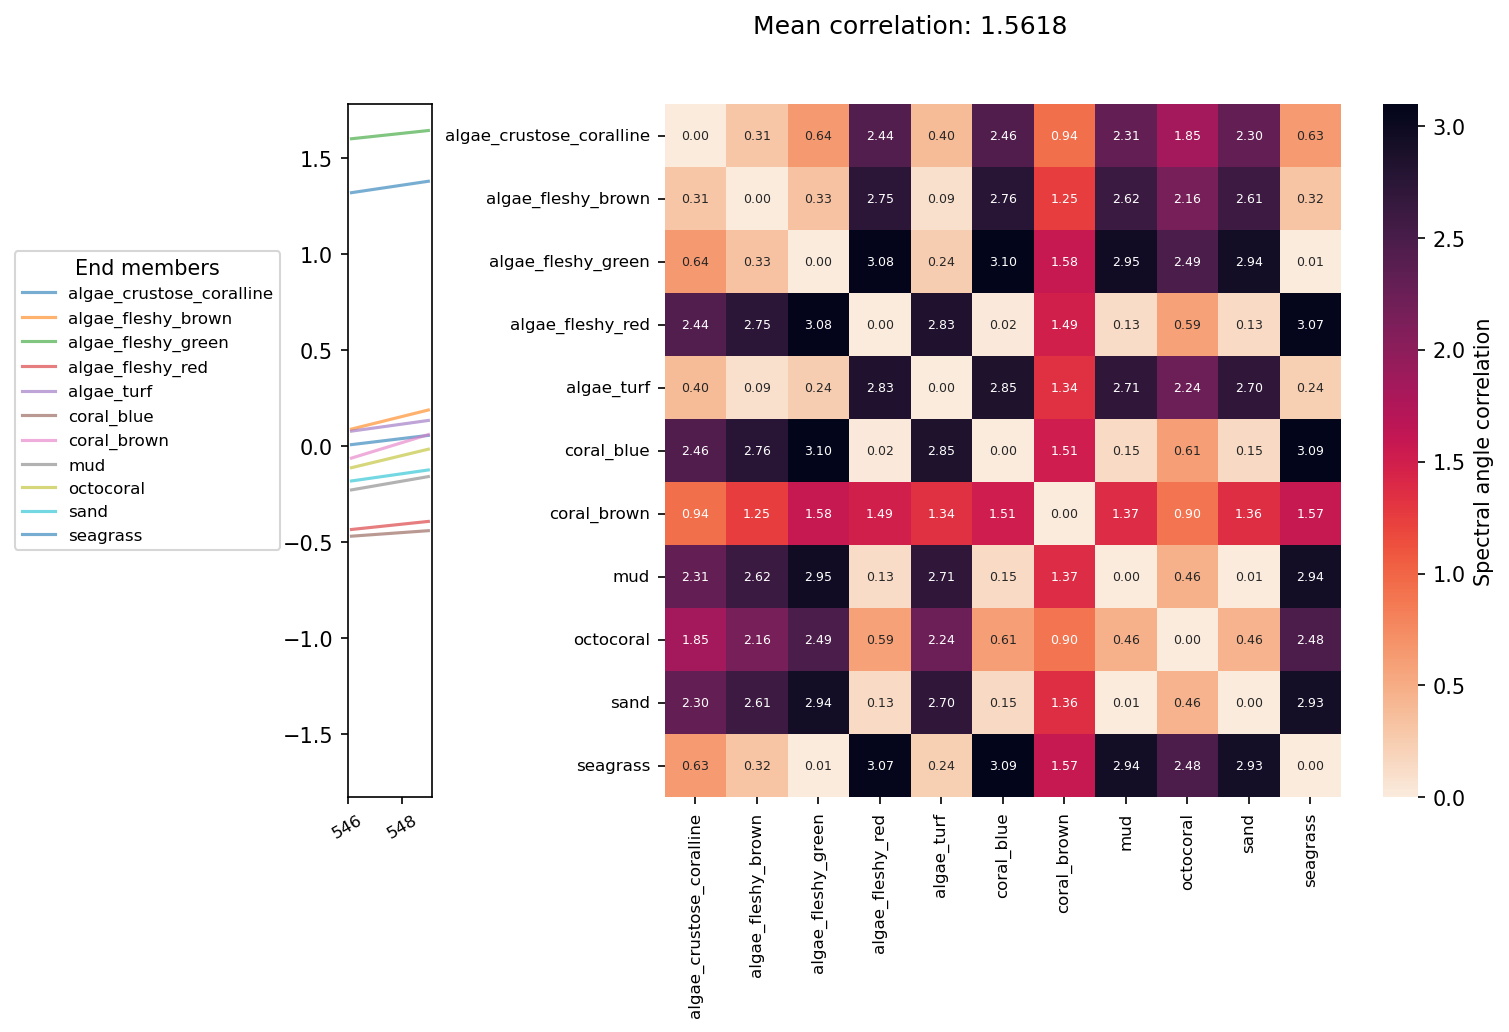

In [14]:
# line_ratio = 
fig, ax = plt.subplots(1,2, figsize=(10, 6), dpi=150, 
                       width_ratios=[0.1,1]
                       )

wv_range = (545, 550)
ids = (prism_spectra.columns > min(wv_range)) & (prism_spectra.columns < max(wv_range))
wvs = prism_spectra.columns[ids]
for endmember in range(end_members_znormscale_array.shape[0]):
    ax[0].plot(wvs, end_members_znormscale_array[endmember, ids], label=cats[endmember], alpha=0.6)
    
corr_mat = spectrum_utils.spectral_angle_correlation_matrix(end_members_znormscale_array[:, ids])
sns.heatmap(corr_mat, annot=True, fmt='.2f', annot_kws={'fontsize':6}, ax=ax[1], cmap='rocket_r', cbar_kws={'orientation': "vertical"})
# calculate mean of corr_mat
mean_corr = corr_mat[np.triu_indices(corr_mat.shape[0], k=1)].mean()

# formatting
ax[0].legend(title="End members", fontsize=8, bbox_to_anchor=(-.7, 0.8))
ax[0].set_ylim(end_members_znormscale_array.min(), end_members_znormscale_array.max())  # set y-axis limits to min/max of end-members to compare to whole spectrum
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=8)
ax[1].collections[0].colorbar.set_label("Spectral angle correlation")
ax[1].set_xticklabels(cats, rotation=90, fontsize=8)
ax[1].set_yticklabels(cats, rotation=0, fontsize=8)
plt.suptitle(f"Mean correlation: {mean_corr:.4f}")
plt.subplots_adjust(wspace=0.5);

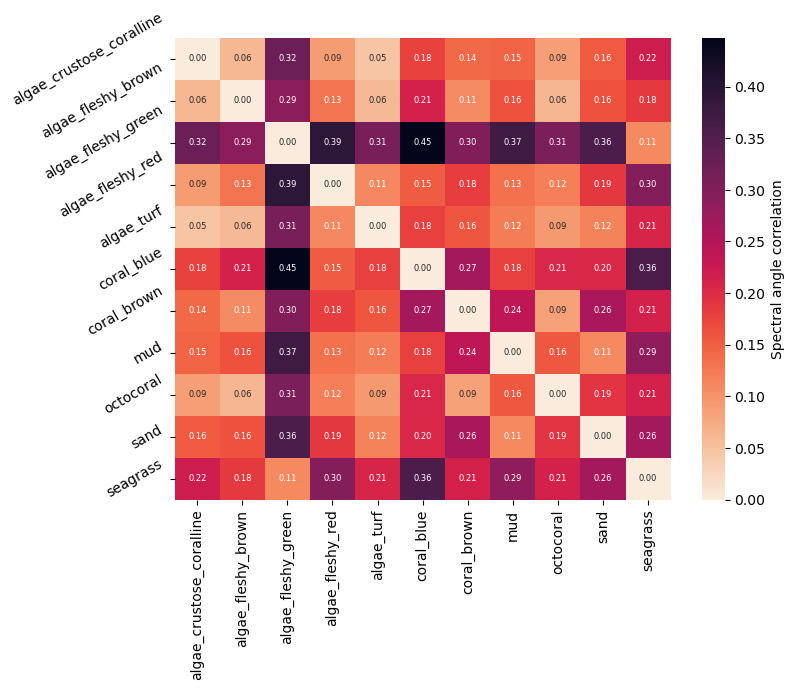

In [15]:
# visualise correlation between end-members
plt.figure(figsize=[8,6])
ax = sns.heatmap(spectrum_utils.spectral_angle_correlation_matrix(end_member_array), annot=True, fmt='.2f', annot_kws={'fontsize':6}, cmap='rocket_r')
ax.collections[0].colorbar.set_label("Spectral angle correlation")
ax.set_xticklabels(cats, rotation=90)
ax.set_yticklabels(cats, rotation=30);

## Fitting spectra

In [16]:
# load in endmember data
AOD_sub = AOP_model.loc[prism_spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

rerun = True

# Create a partial function with additional arguments fixed
partial_wrapper = partial(spectrum_utils._wrapper, prism_spectra=prism_spectra, AOD_args=AOD_args, end_member_array=end_member_array)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

    fits = pd.DataFrame(result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(cats))
    # fits.to_csv('tmp/fits_avg_endmembers_new.csv')
# else load in values from tempfile
else:
    fits = pd.read_csv('tmp/fits_avg_endmembers_new.csv', index_col=0)
    # fits = pd.read_csv('tmp/fits_avg_endmembers_og.csv', index_col=0) # original
    
fits.head()

  0%|          | 0/1938 [00:00<?, ?it/s]

,bb,K,H,algae_crustose_coralline,algae_fleshy_brown,algae_fleshy_green,algae_fleshy_red,algae_turf,coral_blue,coral_brown,mud,octocoral,sand,seagrass
0,0.259998,0.423906,3.222077,0.241290,0.007809,0.010587,0.087700,0.230344,0.191340,0.021053,0.000103,0.000000,0.194189,0.044394
1,0.261078,0.356994,3.219613,0.246717,0.024569,0.053597,0.077150,0.218941,0.257992,0.083144,0.000055,0.000000,0.161643,0.081080
2,0.259289,0.417851,3.292374,0.273783,0.032154,0.019548,0.069755,0.241381,0.252099,0.053127,0.000819,0.012578,0.139618,0.049177
3,0.280272,0.439106,3.313381,0.236896,0.032383,0.051046,0.076985,0.234246,0.255053,0.033608,0.000507,0.057731,0.165213,0.016472
4,0.259226,0.411345,3.149967,0.252967,0.013193,0.028929,0.065793,0.215120,0.164805,0.003963,0.003538,0.025886,0.201879,0.043790


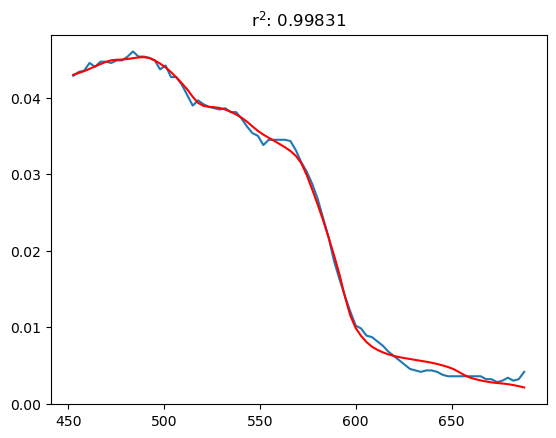

In [38]:
# example of curve fit: a precursor to fitting via scipy.minimize
i = 888
plt.plot(prism_spectra.columns, prism_spectra.loc[i]);

AOD_sub = AOP_model.loc[prism_spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

# fitting curve with scalar Rb
# function needs to be passed with lambda function since we need to pass additional arguments (AOD_args)
p, cov = curve_fit(lambda x, bb, Kd, Rb, H: spectrum_utils.sub_surface_reflectance(x, bb, Kd, Rb, H, *AOD_args),
                   prism_spectra.columns, # x values series (wavelengths)
                   prism_spectra.loc[i],  # y values (example spectrum)
                   p0=[0.1, 0.1, 0, 0],    # initialisation values for bb, Kd, Rb, H
                   # value bounds (from AOP model). Rb min bound 0 since reflectance necessarily positive:
                   bounds=([0, 0.01688, 0, -1], [0.41123, 3.17231, np.inf, np.inf]))    
plt.plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance(prism_spectra.columns, *p, *AOD_args), color='red')
# calculate spectrum r2
r2 = r2_score(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance(prism_spectra.columns, *p, *AOD_args))
plt.title(f"r$^2$: {r2:.5f}");

In [19]:
# assign nans to r2 column
fits['r2'] = np.nan

for i, row in tqdm(fits.iterrows(), total=len(fits)):
    bb_m, bb_c, Kd_m, Kd_c = AOD_args
    bb, K, H = row.values[:3]
    # pred = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb_m, bb_c, Kd_m, Kd_c, *row.values[:3])
    pred = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *row.values[3:-1])
    fits.loc[i, 'r2'] = r2_score(prism_spectra.loc[i], pred)

  0%|          | 0/1938 [00:00<?, ?it/s]

In [20]:
# # assign nans to r2 column
# fits['r2'] = np.nan

# for i, row in tqdm(fits.iterrows(), total=len(fits)):
    
#     pred = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, *row.values[:-1], *AOD_args)
#     fits.loc[i, 'r2'] = r2_score(prism_spectra.loc[i], pred)

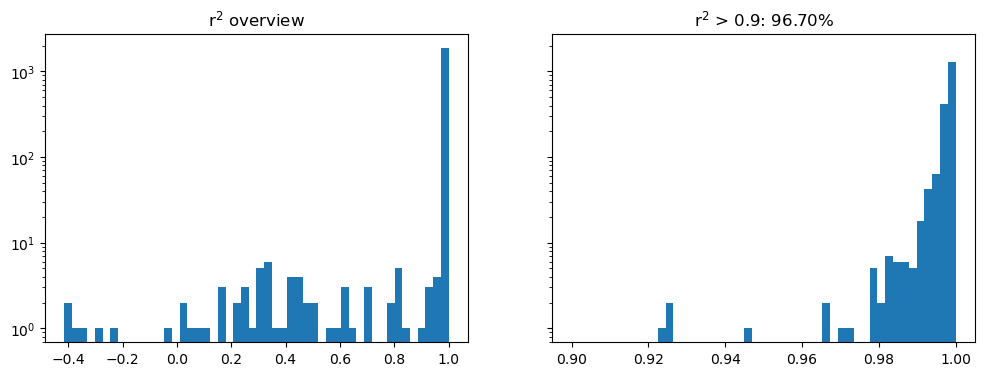

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].hist(fits.r2, bins=50);
ax[0].set_yscale('log')
ax[0].set_title("r$^2$ overview")

min_r2 = 0.9
ax[1].hist(fits.r2, bins=np.linspace(min_r2, 1, 50));
ax[1].set_title(f"r$^2$ > 0.9: {100*sum(fits.r2 > min_r2)/len(fits):.2f}%");

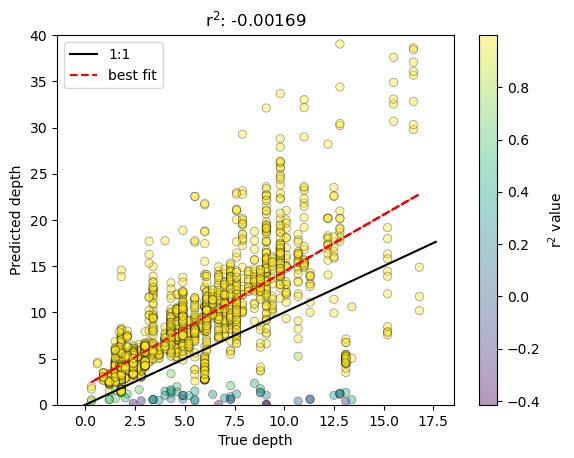

In [22]:
fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth, fits.H, alpha=0.4, c=fits.r2, edgecolor='k', lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')

# calculate fits
p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
ax.plot(validation_data.Depth, pred, color='r', ls='--', label="best fit")
# formatting
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth")
ax.set_ylabel("Predicted depth")
ax.set_ylim(0,40)
fig.colorbar(ma, label="r$^2$ value")
ax.legend()

Text(0.5, 0.98, 'r$^2$: 0.9973 (spectrum 888)')

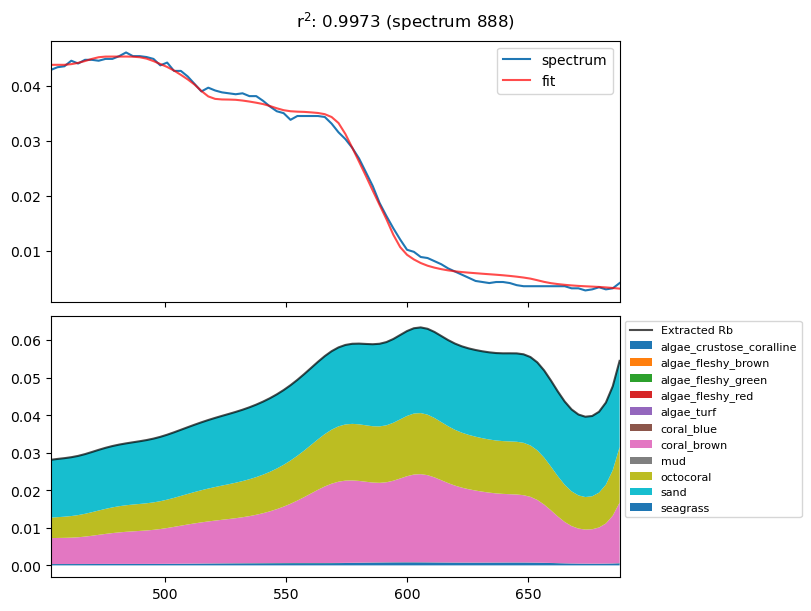

In [43]:
i = 888

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum');

bb, K, H = fits.loc[i].values[:3]
axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *fits.loc[i].values[3:-1]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(end_member_array, *fits.loc[i].values[-12:-1]), color='k', alpha=0.7, label='Extracted Rb')
axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = end_member_array * fits.loc[i].values[-12:-1].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(cats, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)
plt.suptitle(f"r$^2$: {fits.loc[i].r2:.4f} (spectrum {i})")

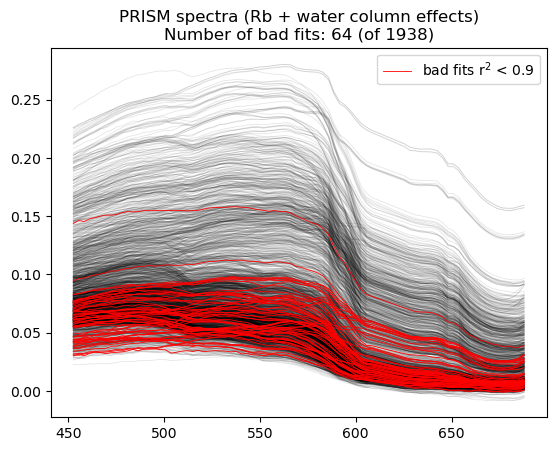

In [24]:
threshold = 0.9

bad_fits = fits[fits.r2 < threshold]
good_fits = fits[fits.r2 >= threshold]

plt.title("")
plt.plot(prism_spectra.columns, prism_spectra.loc[bad_fits.index].values.T, color='red', lw=0.6)
plt.plot(prism_spectra.columns, prism_spectra.loc[good_fits.index].values.T, color='k', alpha=0.1, lw=0.6, zorder=-2);
plt.plot([], [], color="red", lw=0.6, label=f"bad fits r$^2$ < {threshold}")
plt.title(f'PRISM spectra (Rb + water column effects)\nNumber of bad fits: {bad_fits.shape[0]} (of {len(fits)})')
plt.legend();

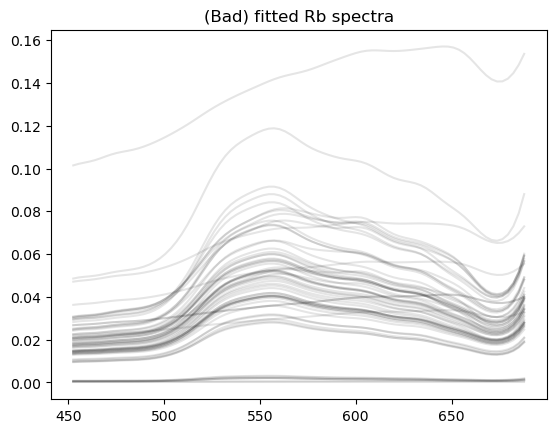

In [25]:
fig, ax = plt.subplots()
ax.set_title("(Bad) fitted Rb spectra")

for i, row in bad_fits.iterrows():
    Rb = spectrum_utils.Rb_endmember(end_member_array, *fits.loc[i, cats].values)
    ax.plot(prism_spectra.columns, Rb, color='black', alpha=0.1)

In [26]:
# plot bb, K, H
fig = px.scatter_3d(fits, x='bb', y='K', z='H', color='r2', 
                    color_continuous_scale='viridis', opacity=0.5,
                    labels={'r2': 'R-squared'})

fig.show()

In [27]:
# map between in-situ validation data and endmember categories
endmember_map = {
    'algae_crustose_coralline': ['algCCA'],
    'algae_fleshy_brown': ['algMacBrn'],
    'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'],
    'algae_fleshy_red': ['algMacRed'],
    'algae_turf': ['algTurf'],
    'coral_blue': [],
    'coral_brown': ['crlCoral'],
    'mud': ['sedMud'],
    'octocoral': ['othOcto'],
    'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
    'seagrass': ['othSeagr'],
    # 'other': ['othClam', 'othInvert', 'othOther', 'othSponge', 'othUrchin']  # ignoring as max count is 3, and they don't fit categories well
}

# create empty dataframe with correct rows and column headers
validation_data_mapped = pd.DataFrame(index=validation_data.index, columns=endmember_map)

for end_member_type, validation_fields in endmember_map.items():
    # fill in validation data with sum of all fields in the category
    validation_data_mapped.loc[:, end_member_type] = validation_data.loc[:, validation_fields].sum(axis=1) 
# validation_data_mapped

# normalise validation data
validation_data_mapped_norm = validation_data_mapped.divide(validation_data_mapped.sum(axis=1), axis=0) # first sum along rows, then divide by row sum
# normalise fitted data
fits_norm = fits.loc[:, cats]
fits_norm = fits_norm.divide(fits_norm.sum(axis=1), axis=0)

In [28]:
# assign new 'coral' class as sum of blue and brown coral
validation_data_mapped_norm['coral'] = validation_data_mapped_norm[['coral_blue', 'coral_brown']].sum(axis=1)
fits_norm['coral'] = fits_norm[['coral_blue', 'coral_brown']].sum(axis=1)

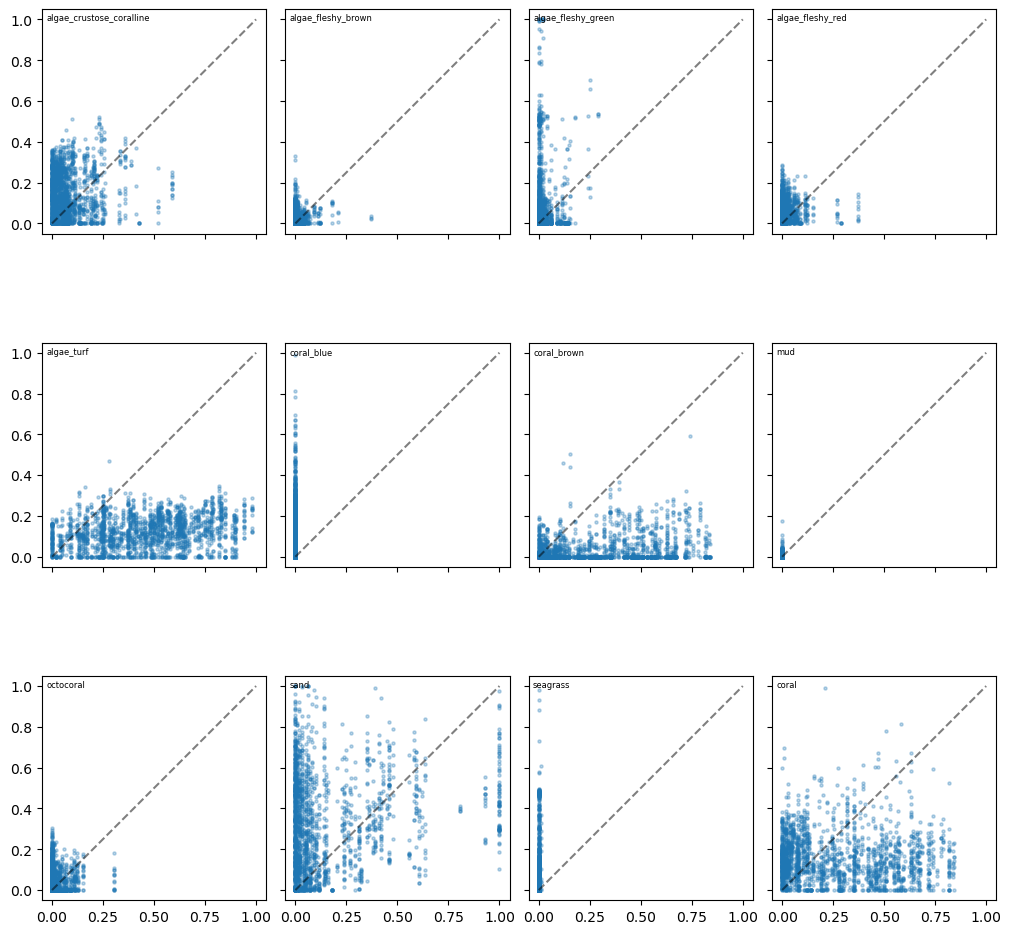

In [29]:
fig, axs = plt.subplots(3, 4, figsize=[10, 10], sharex=True, sharey=True, constrained_layout=True)

for endmember, ax in zip(fits_norm.columns, axs.flat):
    ax.scatter(validation_data_mapped_norm[endmember], fits_norm[endmember], s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    ax.axis('square')
    ax.plot([0,1], [0,1], color='k', ls='--', alpha=0.5)

In [30]:
new_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass'],
    'CCA': ['algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

pc_end_members = {}
pc1_end_members = {}

for cat in new_cats:
    ind = df.index.isin(new_cats[cat])
    pc_end_members[cat] = df.loc[ind].mean(axis=0)
    
    pca = PCA(1).fit(df.loc[ind])
    pc1_end_members[cat] = pca.components_[0]
    
pc_end_member_array = np.array([spectrum.values for spectrum in pc_end_members.values()])
pc1_end_member_array = np.array([spectrum for spectrum in pc1_end_members.values()])


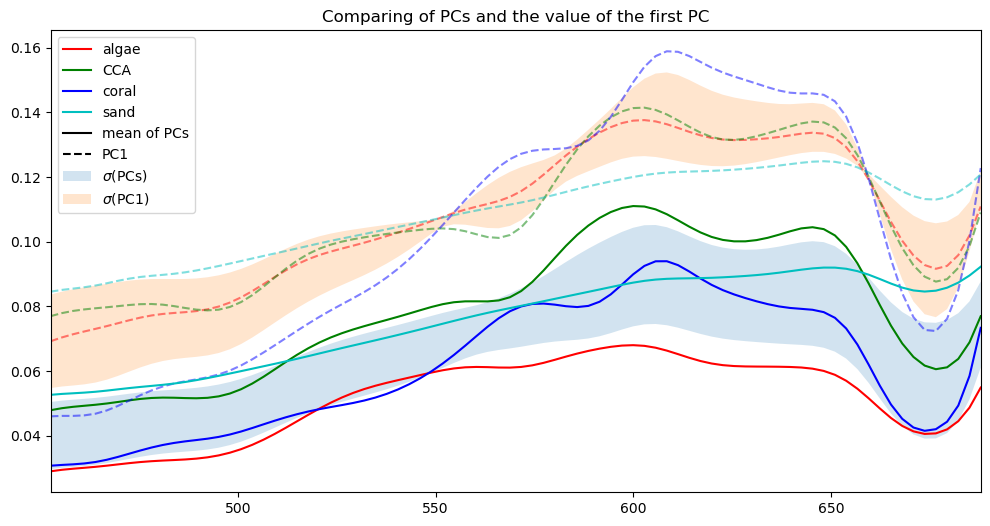

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
i = 1
cs = ['r', 'g', 'b', 'c']
for i_pca_end_member in range(pc_end_member_array.shape[0]):
    plt.plot(prism_spectra.columns, pc_end_member_array[i_pca_end_member], color=cs[i_pca_end_member], label=list(pc_end_members.keys())[i_pca_end_member])
    plt.plot(prism_spectra.columns, pc1_end_member_array[i_pca_end_member], ls='--', color=cs[i_pca_end_member], alpha=0.5)

plt.plot([],[], color='k', label='mean of PCs')
plt.plot([],[], color='k', ls='--', label='PC1')

# plot standard deviations
pc_endmember_std = pc_end_member_array.std(axis=0)
pc_endmember_mean = pc_end_member_array.mean(axis=0)
ax.fill_between(prism_spectra.columns, pc_endmember_mean - pc_endmember_std, pc_endmember_mean + pc_endmember_std, alpha=0.2, label="$\\sigma$(PCs)")
    
pc1_endmember_std = pc1_end_member_array.std(axis=0)
pc1_endmember_mean = pc1_end_member_array.mean(axis=0)
ax.fill_between(prism_spectra.columns, pc1_endmember_mean - pc1_endmember_std, pc1_endmember_mean + pc1_endmember_std, alpha=0.2, label="$\\sigma$(PC1)")

plt.title('Comparing of PCs and the value of the first PC')
plt.xlim(prism_spectra.columns.min(), prism_spectra.columns.max())
plt.legend();

In [32]:
# # not currently used
# pc_end_member_array_norm = pc_end_member_array - pc_end_member_array.min(axis=1)[:, None]
# pc_end_member_array_norm /= pc_end_member_array_norm.max(axis=1)[:, None]

In [33]:
partial_wrapper = partial(spectrum_utils._wrapper, prism_spectra=prism_spectra, AOD_args=AOD_args, end_member_array=pc_end_member_array)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

  0%|          | 0/1938 [00:00<?, ?it/s]

In [34]:
pc_fits = pd.DataFrame(result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(new_cats))
pc_fits.head()

,bb,K,H,algae,CCA,coral,sand
0,0.381278,0.642047,3.485084,0.011607,0.777032,0.041827,1.024054
1,0.403988,0.642731,3.451881,0.260744,0.723884,0.134219,0.682730
2,0.315544,0.377005,3.387865,0.495202,0.351048,0.234613,0.755076
3,0.411230,0.637272,3.560667,0.327236,0.636779,0.281125,0.551100
4,0.363147,0.601745,3.365497,0.108785,0.536298,0.006082,1.385374


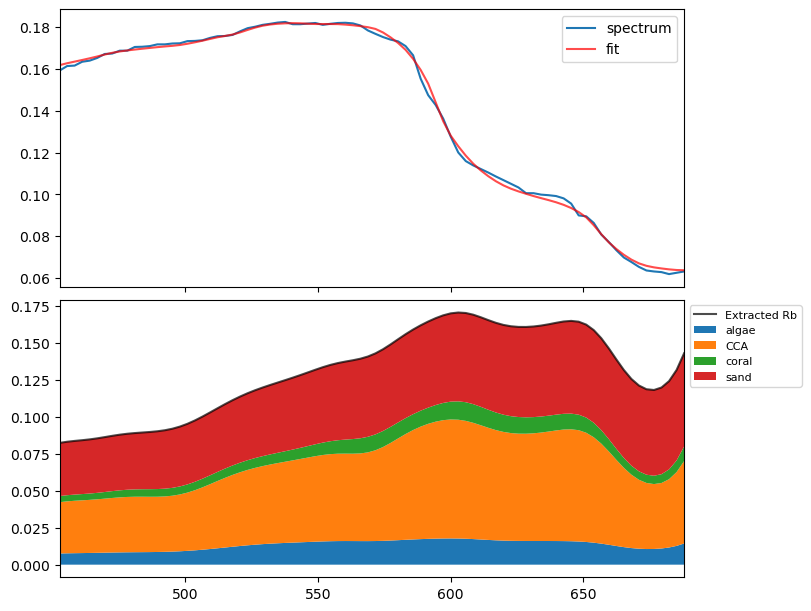

In [35]:
i = 1

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum');
bb, K, H = pc_fits.iloc[i,:][:3]    # TODO: is there a better way to make this generic? Probably via feeding [bb, K, H] as single argument (a list)
axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, pc_end_member_array, bb, K, H, AOD_args, *pc_fits.iloc[i,:][3:]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(pc_end_member_array, *pc_fits.iloc[i,:][-4:]), color='k', alpha=0.7, label='Extracted Rb')

axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = pc_end_member_array * pc_fits.iloc[i,:][-4:].values.reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(pc_end_members, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)


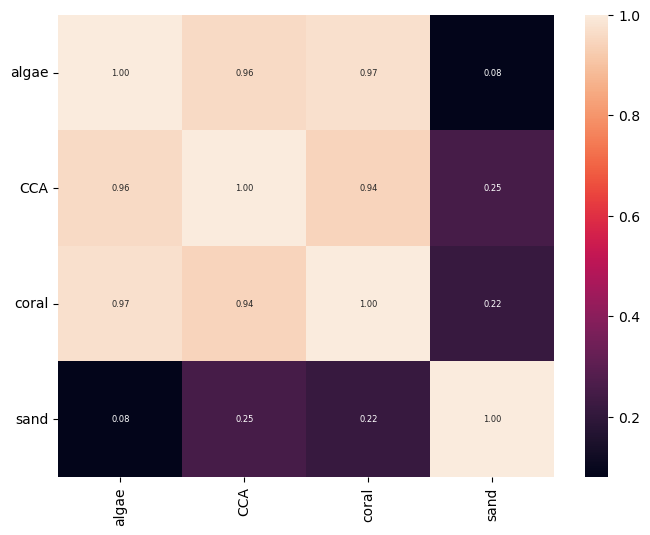

In [36]:
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(pc_end_member_array[:, 44:]), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(pc_end_members.keys(), rotation=90)
ax.set_yticklabels(pc_end_members.keys(), rotation=0);

## Simulation

TypeError: cannot unpack non-iterable int object

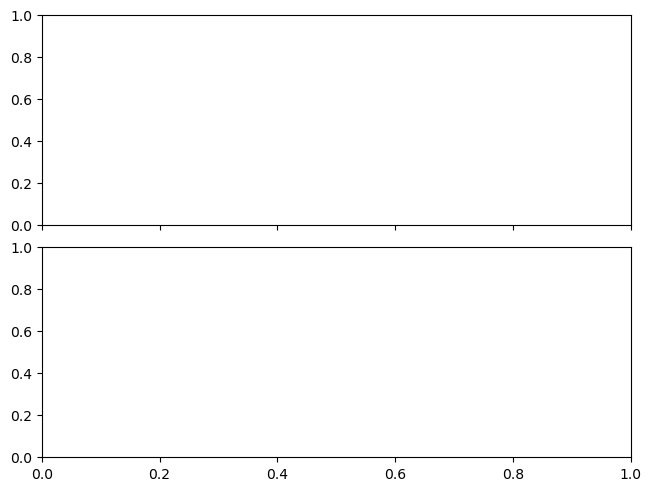

In [37]:
bb = 0.02
K = 0.2
H = 10

Rb0 = 0  # algae
Rb1 = 0  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand

def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, bb_m, bb_c, Kd_m, Kd_c):
    Rb = spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, 0, 0, 0, 0, *AOD_args), label='Rb=0')

cmap = plt.cm.viridis
cnorm = Normalize(vmin=0, vmax=6)

for Rb2 in np.linspace(0, 6, 10):

    sim = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOD_args) 
    # sim += np.random.normal(0, 1e-4, len(prism_spectra.columns))

    axs[0].plot(prism_spectra.columns, sim, color=cmap(cnorm(Rb2)))

    axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3), color=cmap(cnorm(Rb2)))

ma = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)
fig.colorbar(ma, ax=axs[0])

In [ ]:
# investigating effect of adding noise
bb = 0.02
K = 0.2
H = 5

Rb0 = 0.1  # algae
Rb1 = 0.25  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand



sim = spectrum_utils.sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOD_args) 
sim += np.random.normal(0, 1e-4, len(wv))

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(wv, spectrum_utils.sub_surface_reflectance_Rb(wv, bb, K, H, 0, 0, 0, 0, *AOD_args), label='Rb=0')

axs[0].plot(wv, sim)

axs[1].plot(wv, spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3), color='C1')

w = 1

fit = minimize(spectrum_utils.objective_fn_w,
            x0=[0.1, 0.1, 0] + [0] * 4,
            args=(sim, w, *AOD_args),
            bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [(0, np.inf)] * 4, tol=1e-9)

pred = spectrum_utils.sub_surface_reflectance_Rb(wv, *fit.x, *AOD_args)
axs[0].plot(wv, pred, color='C2', alpha=0.7, label='fit')

axs[1].plot(wv, spectrum_utils.Rb_endmember(*fit.x[-4:]), color='C2', alpha=0.7, label='Extracted Rb')

fit.x[-4:] / [Rb0, Rb1, Rb2, Rb3]

In [ ]:
plt.plot(wv,1 + 4 * stats.norm.pdf(wv, loc=570, scale=20))


In [ ]:
plt.plot(wv,1 + 4 * stats.norm.cdf(wv, loc=580, scale=20))